# **Boston House Price Prediction**


## **Description**

The data comprises variations in house prices derived from information collected by the U.S. Census Service concerning housing in the area of [Boston, MA](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).

The following describes the dataset columns:
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

Variable #14 (medv) seems to be censored at 50.00 (corresponding to a median price of $50,000); Censoring is suggested by the fact that the highest median price of exactly $50,000 is reported in 16 cases, while 15 cases have prices between $40,000 and $50,000, with prices rounded to the nearest hundred

## **Objectives**

The objectives of this portfolio are twofold:
1. to identify the variables that influence increasing house prices through exploratory data analysis.
2. to predict house prices using machine learning models.

## **Dataset Source**

https://www.kaggle.com/datasets/vikrishnan/boston-house-prices

## **Data Preparation**

### **1. Import Libraries**

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant 
from sklearn.preprocessing import StandardScaler as ss

### **2. Load Data**

In [71]:
df = pd.read_csv('boston.csv')

### **3. Function Helpers**

In [72]:
def data_info(data) :
    pd.set_option('display.max_rows',None)
    missing_values = data.isnull().sum()
    missing_perc = (missing_values/len(data))*100
    data_type = data.dtypes
    num_unique = data.nunique()

    print (f'Rows,Columns {data.shape}')
    print (f'Duplicated Values {data.duplicated().sum()}')
    print('=====')

    check_df = pd.DataFrame ({'missingValue' : missing_values,
                          'percentMissing' : missing_perc,
                          'DataType' : data_type,
                          'Unique' : num_unique}).sort_values('percentMissing',ascending=False)

    return check_df

In [73]:
def outlier(df) :
    for key, value in df.items():
        q1 = value.quantile(0.25)
        q3 = value.quantile(0.75)
        iqr = q3-q1
        lower = q1 - (1.5 * iqr)
        upper = q3 + (1.5 * iqr)

        value_col = value[(value <= lower) | (value >= upper)]
        perc = np.shape(value_col)[0] * 100.0 / np.shape(df)[0]

        print("%s outliers = %.2f%%" % (key, perc))
        print (f' outlier lower limit : {lower} \n outlier upper limit : {upper}')
        print()

In [74]:
def mean_errors(train_test, x, y):
    print(f'RMSE for {train_test} data is {np.sqrt(mean_squared_error(x, y))}')
    print(f'MAE for {train_test} data is {mean_absolute_error(x, y)}')
    print("MAPE for %s data is %.2f%%" % (train_test, mean_absolute_percentage_error(x, y)*100))

In [177]:
def mean_score (model, X, y, isError=False, text=None):
    estimation = model.predict(X)
    mae  = mean_absolute_error(y, estimation)
    mape = mean_absolute_percentage_error(y, estimation)*100
    rmse = np.sqrt(mean_squared_error(y, estimation))
    r2   = r2_score(y, estimation)
    if isError == True:
        print(f'{text} error:')
    else:
        print(f'Training model: {model}')
    print(f"R2: {r2:.4f}\tRMSE: {rmse:.5f}\tMAE: {mae:.5f}\tMAPE: {mape:.2f}%\n")

def mean_scores_alpha_test (models, X, y):
    for model in models:
        mean_score(model, X, y)

In [75]:
def check_dependency (data, x, y) :

    ftest, p_val = f_oneway(data[x],data[y])
    alpha = 0.05

    print(f'=== feature: {x} === target: {y} ===')

    if p_val < alpha :
        print (f'p-value: {p_val} < {alpha} \nFeature and Target has significant influence\nftest : {ftest}')
        print()

    else :
        print (f'p-value: {p_val} > {alpha} \nFeature and Target does not have significant influence\nftest : {ftest}')
        print()

In [76]:
def pearson_test (data, x, y) :

    corr, p_val = pearsonr(data[x],data[y])
    alpha = 0.05

    print(f'=== feature: {x} === target: {y} ===')

    if p_val < alpha :
        print (f'p-value: {p_val} < {alpha} \nFeature and Target has significant influence\nCorrelation Coefficient : {corr}')
        print()

    else :
        print (f'p-value: {p_val} > {alpha} \nFeature and Target does not have significant influence\nCorrelation Coefficient : {corr}')
        print()

In [187]:
def residualPlot(model, data, target):
  estimation = model.predict(data)
  residual = target - estimation
  data = pd.DataFrame({
    'predicted_value': estimation,
    'residual': residual})

  # residual plot
  fig, ax = plt.subplots(figsize=(6, 6))
  sns.scatterplot(data, x="predicted_value", y="residual", ax=ax)
  plt.axhline(0)
  plt.title(f"Residual Plot {model}")

In [127]:
def qqPlot(model, data, target):
  estimation = model.predict(data)
  residual = target - estimation

  std_resid = ss().fit_transform(residual.reshape(-1,1))
  std_resid = np.array([value for nested_array in std_resid for value in nested_array])

  # QQ plot
  fig, ax = plt.subplots(figsize=(6, 6))
  sm.qqplot(std_resid, line='45', ax=ax)
  plt.title(f"QQ Plot {model}");

### **4. Baseline Data Check**

In [77]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [78]:
data_info(df)

Rows,Columns (506, 14)
Duplicated Values 0
=====


,missingValue,percentMissing,DataType,Unique
crim,0,0.0,float64,504
zn,0,0.0,float64,26
indus,0,0.0,float64,76
chas,0,0.0,int64,2
nox,0,0.0,float64,81
rm,0,0.0,float64,446
age,0,0.0,float64,356
dis,0,0.0,float64,412
rad,0,0.0,int64,9
tax,0,0.0,int64,66


In [79]:
#check each data for uniqueness
df_columns = df.columns.tolist()
for column in df_columns:
    print(f"{column} : {df[column].unique()}")
    print('\n')

crim : [6.32000e-03 2.73100e-02 2.72900e-02 3.23700e-02 6.90500e-02 2.98500e-02
 8.82900e-02 1.44550e-01 2.11240e-01 1.70040e-01 2.24890e-01 1.17470e-01
 9.37800e-02 6.29760e-01 6.37960e-01 6.27390e-01 1.05393e+00 7.84200e-01
 8.02710e-01 7.25800e-01 1.25179e+00 8.52040e-01 1.23247e+00 9.88430e-01
 7.50260e-01 8.40540e-01 6.71910e-01 9.55770e-01 7.72990e-01 1.00245e+00
 1.13081e+00 1.35472e+00 1.38799e+00 1.15172e+00 1.61282e+00 6.41700e-02
 9.74400e-02 8.01400e-02 1.75050e-01 2.76300e-02 3.35900e-02 1.27440e-01
 1.41500e-01 1.59360e-01 1.22690e-01 1.71420e-01 1.88360e-01 2.29270e-01
 2.53870e-01 2.19770e-01 8.87300e-02 4.33700e-02 5.36000e-02 4.98100e-02
 1.36000e-02 1.31100e-02 2.05500e-02 1.43200e-02 1.54450e-01 1.03280e-01
 1.49320e-01 1.71710e-01 1.10270e-01 1.26500e-01 1.95100e-02 3.58400e-02
 4.37900e-02 5.78900e-02 1.35540e-01 1.28160e-01 8.82600e-02 1.58760e-01
 9.16400e-02 1.95390e-01 7.89600e-02 9.51200e-02 1.01530e-01 8.70700e-02
 5.64600e-02 8.38700e-02 4.11300e-02 4.46200

#### **Summary 1**

1. There are no duplicates or missing values
2. data types are appropriate as they should be according to each data represented

### **5. Descriptive Statistics**

In [80]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
crim,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
zn,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
indus,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
chas,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
nox,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
rm,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
age,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
dis,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
rad,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
tax,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


#### **Summary 2**

1. `zn` on min, 25%, 50% show 0. It is understandable due to the fact that zoning happens on a conditional state of lots over 25.000 sq.ft.
2. `chas` on min, 25%, 50%, and 75% show 0. It is understandable due to the fact `chas` is categorical feature.

Based on the note given by the dataset provider, we remove data with medv >= 50

In [81]:
df = df[~(df['medv'] >= 50.0)]

In [82]:
data_info(df)

Rows,Columns (490, 14)
Duplicated Values 0
=====


,missingValue,percentMissing,DataType,Unique
crim,0,0.0,float64,489
zn,0,0.0,float64,26
indus,0,0.0,float64,74
chas,0,0.0,int64,2
nox,0,0.0,float64,80
rm,0,0.0,float64,431
age,0,0.0,float64,350
dis,0,0.0,float64,398
rad,0,0.0,int64,9
tax,0,0.0,int64,64


## **Exploratory Data Analysis**

In [83]:
features = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']
target = ['medv']

numerical = ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']


### **1. Check Outliers & Distribution**

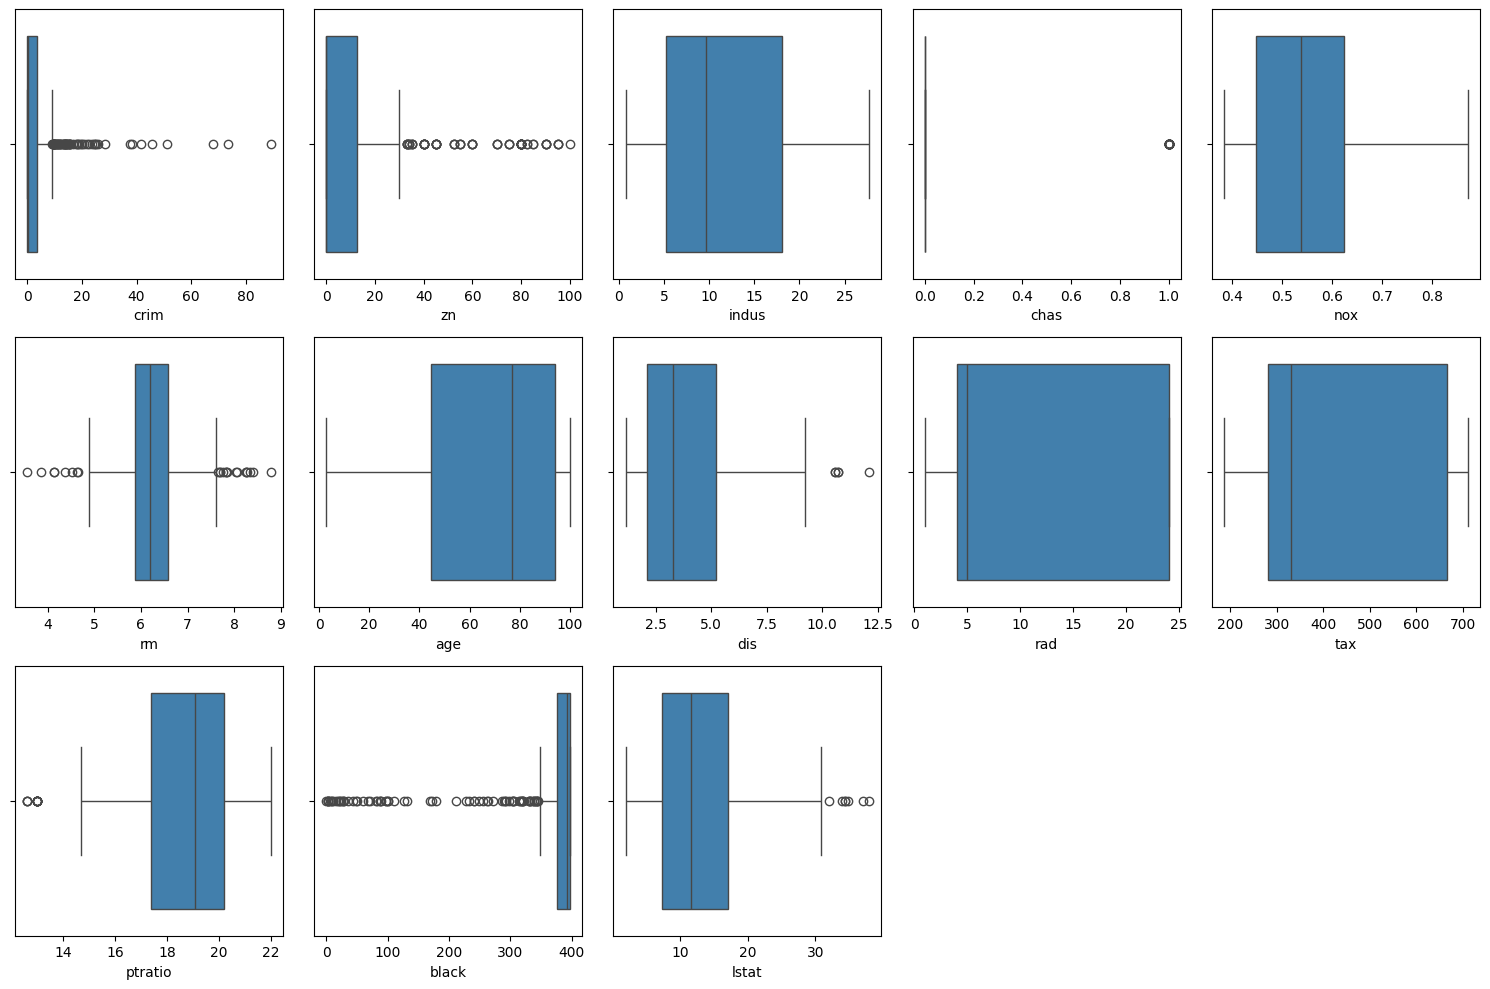

In [84]:
plt.figure(figsize=(15,10))
for i in range(0, len(features)):
  plt.subplot(3, 5, i+1)
  sns.boxplot(x = df[features[i]], hue = i, palette = "tab20c", legend=False)
  plt.tight_layout()

In [85]:
outlier(df)

crim outliers = 13.27%
 outlier lower limit : -5.2660212500000005 
 outlier upper limit : 8.99548875

zn outliers = 13.27%
 outlier lower limit : -18.75 
 outlier upper limit : 31.25

indus outliers = 0.00%
 outlier lower limit : -14.175 
 outlier upper limit : 37.465

chas outliers = 100.00%
 outlier lower limit : 0.0 
 outlier upper limit : 0.0

nox outliers = 0.00%
 outlier lower limit : 0.18650000000000005 
 outlier upper limit : 0.8865

rm outliers = 4.69%
 outlier lower limit : 4.8355000000000015 
 outlier upper limit : 7.623499999999998

age outliers = 0.00%
 outlier lower limit : -29.437500000000014 
 outlier upper limit : 167.8625

dis outliers = 1.02%
 outlier lower limit : -2.5442749999999994 
 outlier upper limit : 9.869924999999999

rad outliers = 0.00%
 outlier lower limit : -26.0 
 outlier upper limit : 54.0

tax outliers = 0.00%
 outlier lower limit : -298.375 
 outlier upper limit : 1244.625

ptratio outliers = 2.65%
 outlier lower limit : 13.199999999999998 
 outlier 

There seems to be outliers on `crim`, `rm`, and `black`. Since they are over 5%, we assume they give additional information and we decide to not remove them. Add to that the data is too small to remove outliers

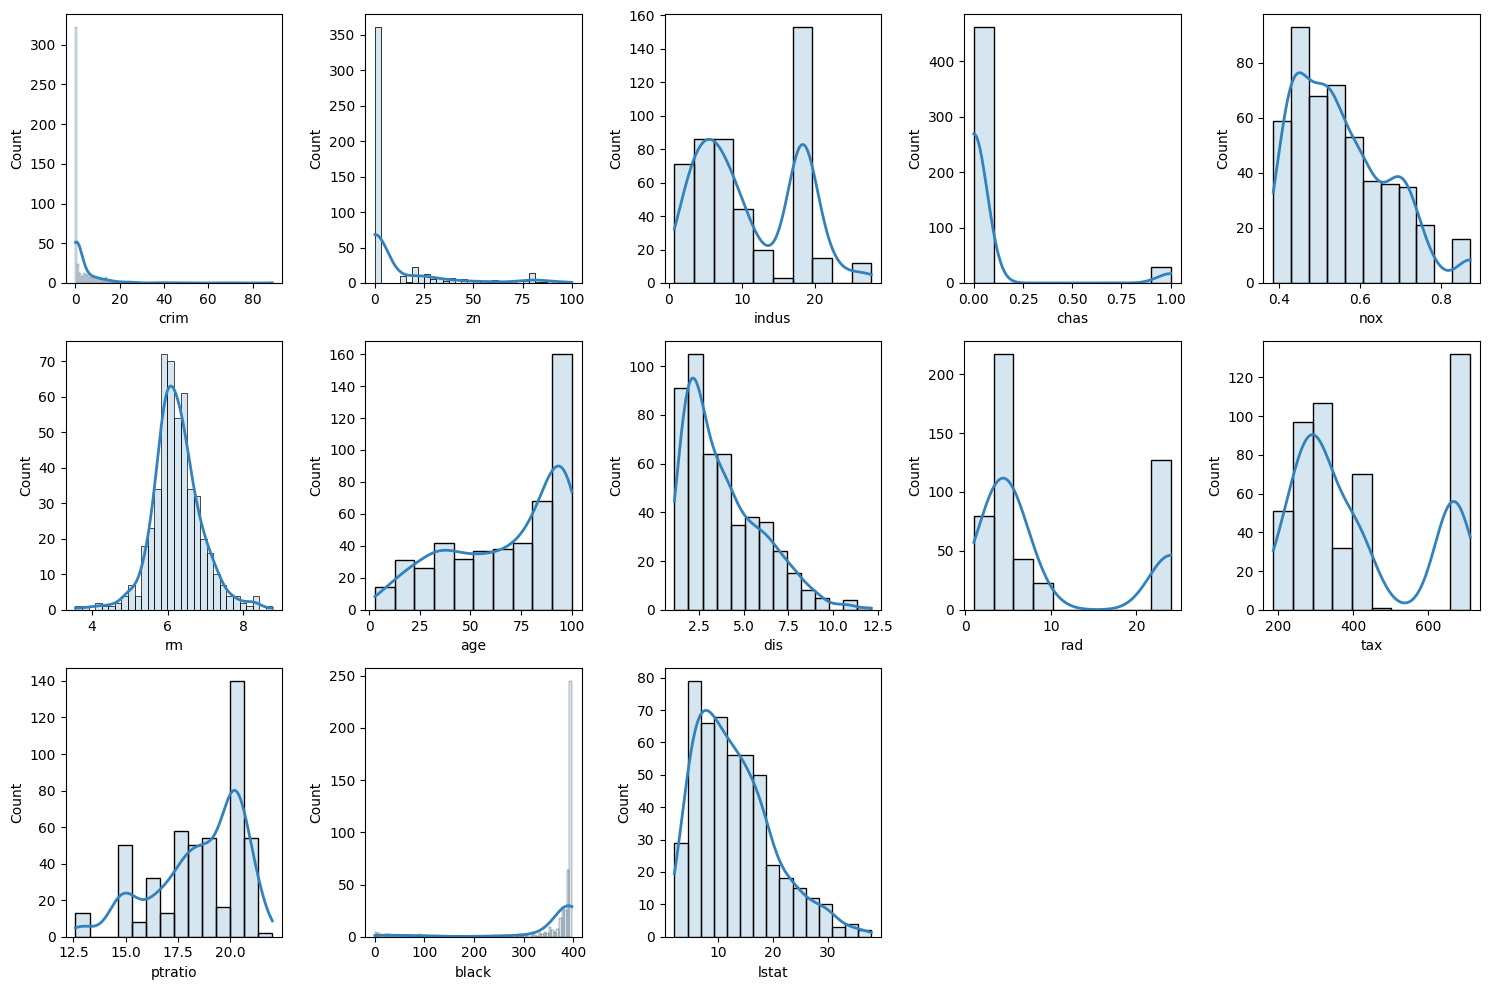

In [86]:
plt.figure(figsize=(15,10))
for i in range(0, len(features)):
  plt.subplot(3, 5, i+1)
  sns.histplot(x=df[features[i]], hue = i, palette = "tab20c", legend=False, kde=True, line_kws={'linewidth': 2}, alpha=0.2)
  plt.xlabel(features[i])
  plt.tight_layout()

### **2. Bivariate & Multivariate Analysis**

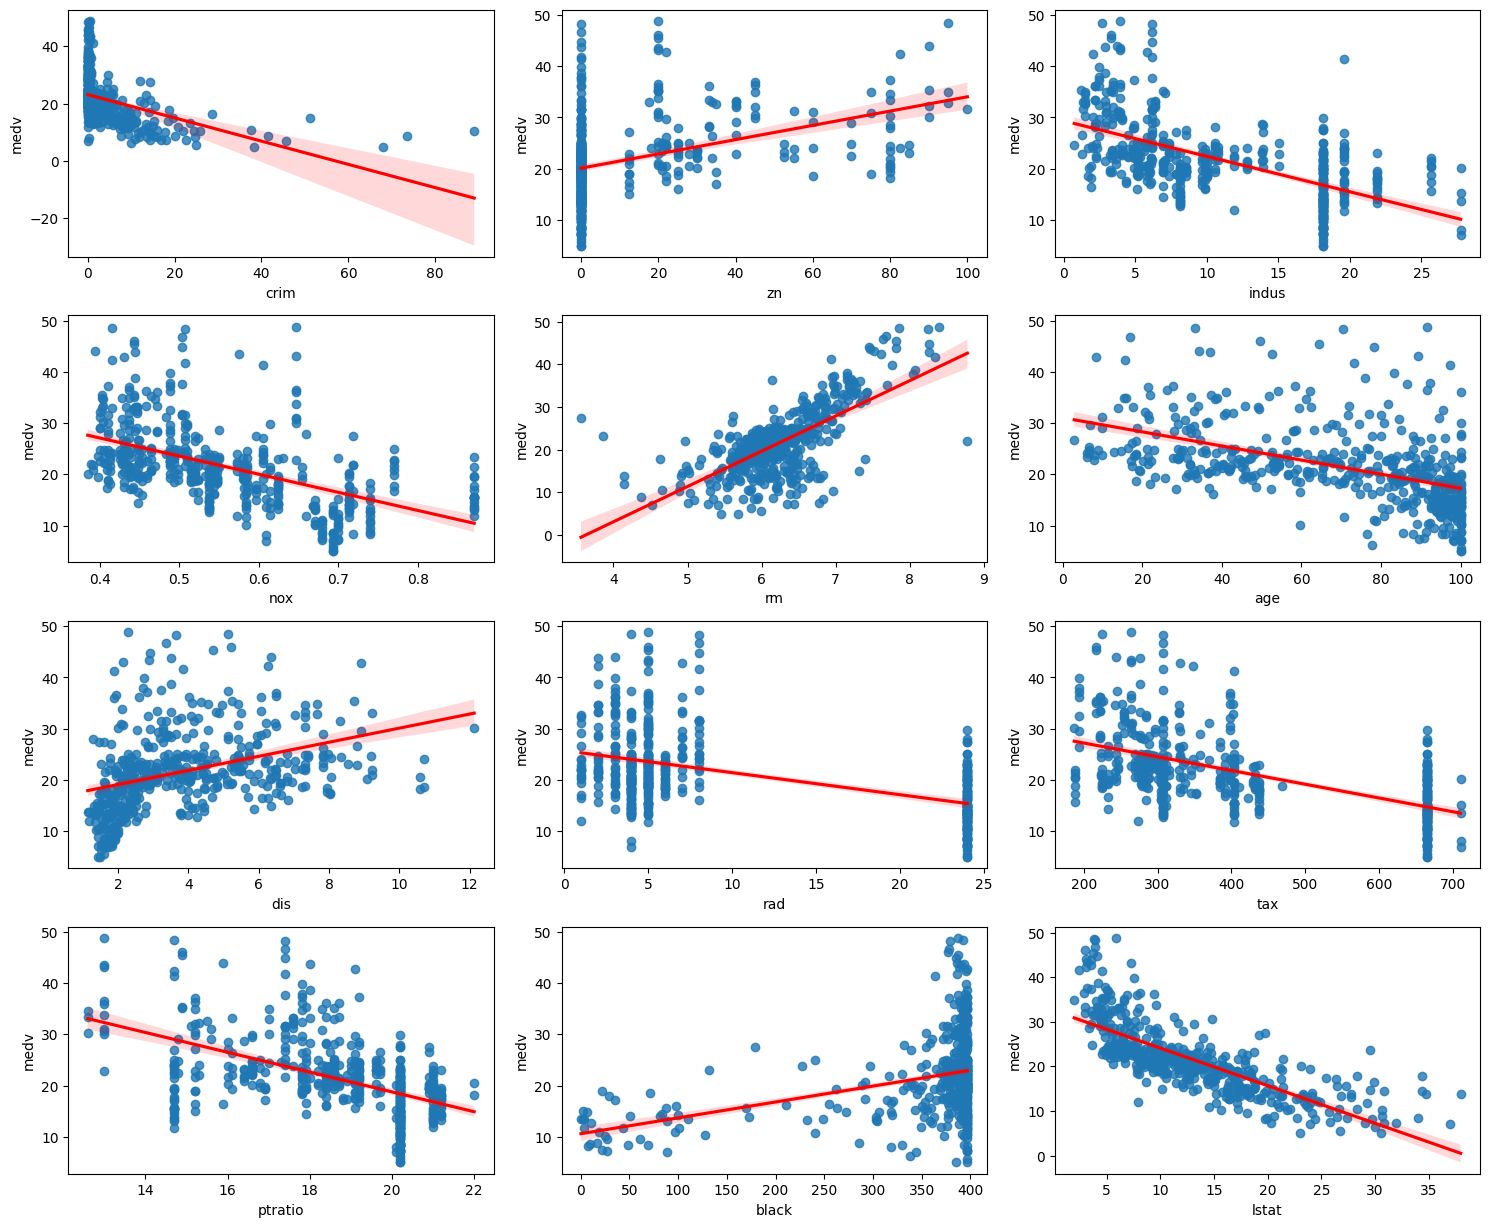

In [87]:
plt.figure(figsize=(15,15))
for i in range(0, len(numerical)):
  plt.subplot(5, 3, i+1)
  sns.regplot(x=numerical[i], y='medv', data=df, line_kws={"color": "red"})
  plt.tight_layout()


<Axes: xlabel='chas', ylabel='medv'>

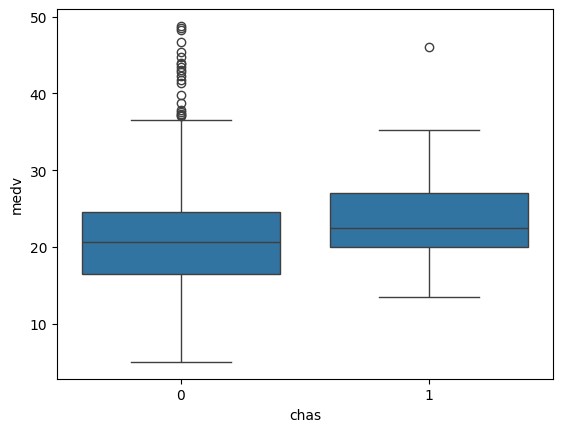

In [88]:
sns.boxplot(x='chas', y='medv', data=df)

#### **Summary 3**

Based on individual feature correlation to the target, the summary is as follows:
1. Environmental Factors: Lower crime rates, NOx concentrations, and newer homes are linked to higher house values.
2. Infrastructure and Accessibility: Greater distance from employment centers and higher accessibility to radial highways tend to lower house values.
3. Economic and Social Factors: Higher industrial proportion, property tax rates, and pupil-teacher ratios negatively impact house values, while more rooms in a house generally increase its value.
4. Demographic Influence: A higher proportion of lower-status individuals decreases house values, while the proportion of Black residents shows a weak positive correlation due to outliers.

### **Hypothesis Testing**

In [89]:
feats = list(df)
feats.remove('chas')
feats.remove('medv')
feats

['crim',
 'zn',
 'indus',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'black',
 'lstat']

In [90]:
for feat in feats:
    pearson_test(df, feat, 'medv')

=== feature: crim === target: medv ===
p-value: 8.114741464324621e-26 < 0.05 
Feature and Target has significant influence
Correlation Coefficient : -0.45011518122771865

=== feature: zn === target: medv ===
p-value: 1.003410780059575e-20 < 0.05 
Feature and Target has significant influence
Correlation Coefficient : 0.40460764217148004

=== feature: indus === target: medv ===
p-value: 3.052570952088004e-49 < 0.05 
Feature and Target has significant influence
Correlation Coefficient : -0.600005228507379

=== feature: nox === target: medv ===
p-value: 5.634111560433537e-36 < 0.05 
Feature and Target has significant influence
Correlation Coefficient : -0.5244510312240699

=== feature: rm === target: medv ===
p-value: 1.4107579483709486e-69 < 0.05 
Feature and Target has significant influence
Correlation Coefficient : 0.686634314206023

=== feature: age === target: medv ===
p-value: 2.3240932486341667e-31 < 0.05 
Feature and Target has significant influence
Correlation Coefficient : -0.492

In [91]:
check_dependency(df, 'chas', 'medv')

=== feature: chas === target: medv ===
p-value: 0.0 < 0.05 
Feature and Target has significant influence
ftest : 3684.217856926918



#### **Summary 4**

All features have proof of significant influence against the target `medv`. We continue with all features to the prediction modelling.

## **Data Splitting**

In [92]:
X = df.drop(columns='medv')
y = df[['medv']]

#first split: pretrain & test
X_pretrain, X_test, y_pretrain, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#second split: train & validation
X_train, X_val, y_train, y_val = train_test_split(X_pretrain, y_pretrain, test_size=0.20, random_state=42)

## **Calculate VIF Score**

In [93]:
X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])], index=X.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,2.079488
2,zn,2.418546
3,indus,3.811354
4,chas,1.049900
5,nox,4.654454
6,rm,1.923483
7,age,3.101301
8,dis,4.071004
9,rad,8.739623
10,tax,10.040523


**Multicollinearity Analysis 1**

Several features with high VIF scores (4 or more):
1. `nox`
2. `dis`
3. `rad`
4. `tax`

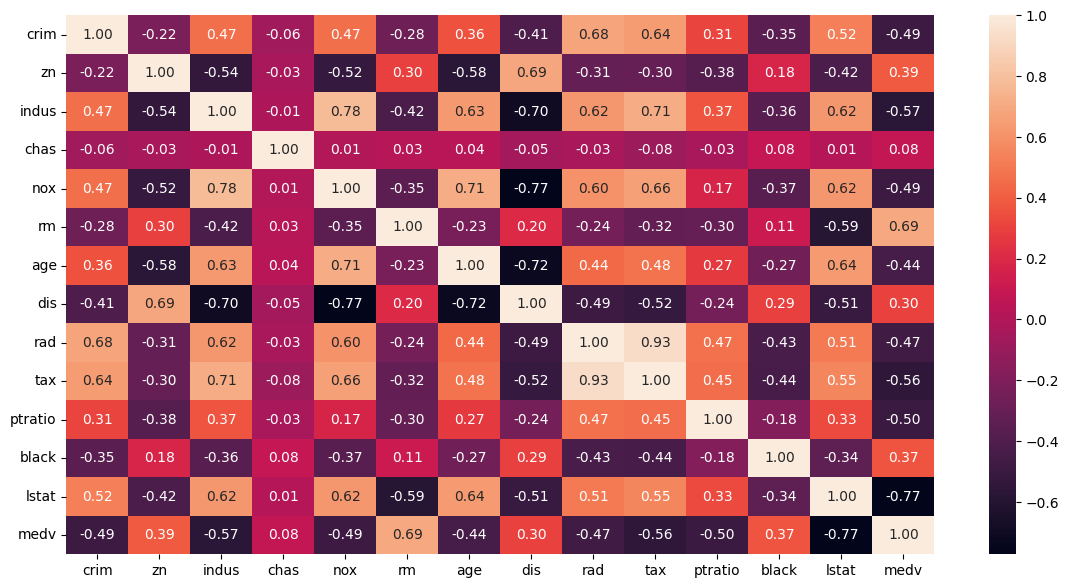

In [94]:
# heatmap correlation to figure out what features to remove due to high VIF
boston_train = pd.concat([X_train, y_train], axis=1)
corr = boston_train.corr()

plt.figure(figsize=(14,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

The feature that has the strongest relationship is rad-tax with `0.85` (above the minimum threshold of 0.8). If we look at the correlation with the target feature (medv), the feature with the highest correlation is `rad`, so what we delete is `tax`.

In [95]:
#drop features
X_train = X_train.drop(columns=['tax'])
X_val = X_val.drop(columns=['tax'])
X_test = X_test.drop(columns=['tax'])

**Recheck VIF**

In [96]:
X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])], index=X.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,2.078939
2,zn,2.284336
3,indus,3.428515
4,chas,1.022502
5,nox,4.587722
6,rm,1.907334
7,age,3.101228
8,dis,4.068802
9,rad,3.021291
10,ptratio,1.708722


**Multicollinearity Analysis 2**

`nox` and `dis` still have high vif score. we need to check further with heatmap correlation.

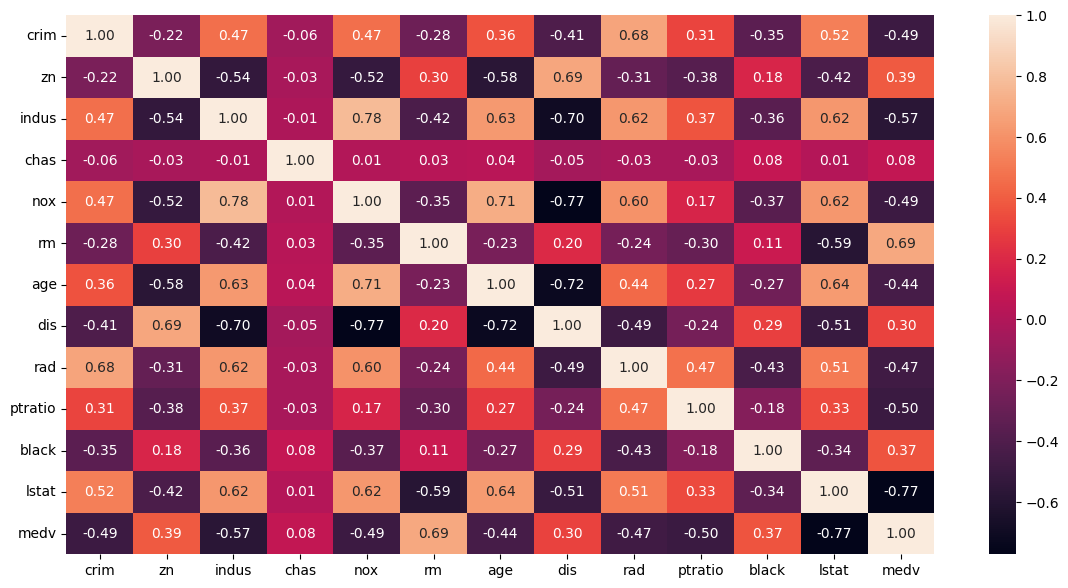

In [97]:
# heatmap correlation to figure out what features to remove due to high VIF
boston_train = pd.concat([X_train, y_train], axis=1)
corr = boston_train.corr()

plt.figure(figsize=(14,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

The heatmap above does not show anything above the 0.8 threshold. However, by rechecking the VIF, we need to delete one of the features that has a high correlation. So I decided to lower the minimum threshold so that something can be removed (assume it to be 0.75)

It can be seen that the features that have a correlation >= 0.75 are `indus` and `nox`, and of the target features, the highest is `nox`, so we delete `indus`

In [98]:
#drop features
X_train = X_train.drop(columns=['indus'])
X_val = X_val.drop(columns=['indus'])
X_test = X_test.drop(columns=['indus'])

In [99]:
#recheck VIF
X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])], index=X.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,2.070635
2,zn,2.283155
3,chas,1.021610
4,nox,4.084805
5,rm,1.844575
6,age,3.099887
7,dis,3.902894
8,rad,2.916562
9,ptratio,1.674663
10,black,1.295123


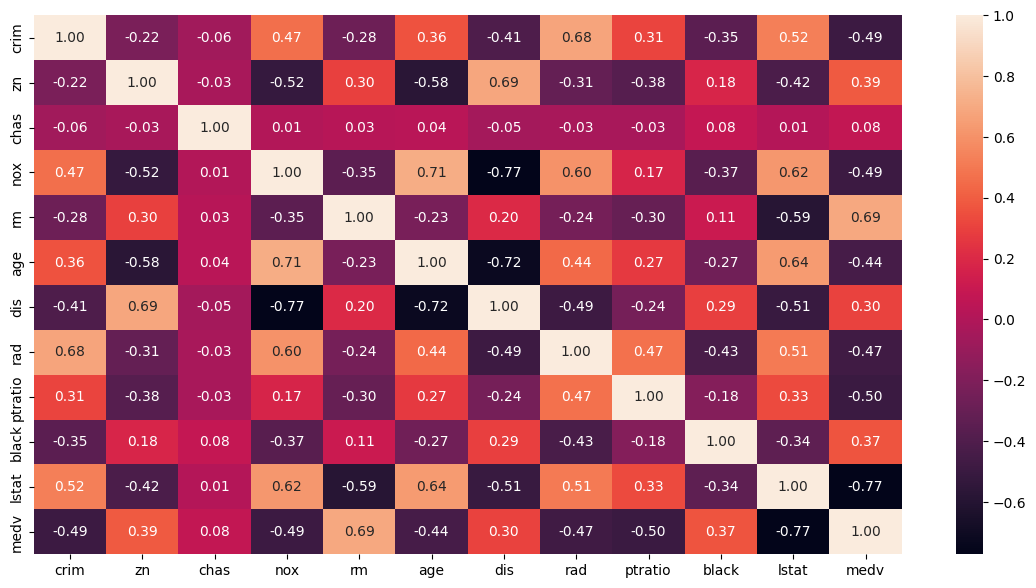

In [100]:
# heatmap correlation to figure out what features to remove due to high VIF
boston_train = pd.concat([X_train, y_train], axis=1)
corr = boston_train.corr()

plt.figure(figsize=(14,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

The heatmap above does not show anything above the 0.75 threshold. However, by rechecking the VIF, we need to delete one of the features that has a high correlation. So I decided to lower the minimum threshold so that something can be removed (assume it to be 0.70)

It can be seen that the features that have a correlation >= 0.75 are `age` and `nox`, and of the target features, the highest is `age`, so we delete `nox`

In [101]:
#drop features
X_train = X_train.drop(columns=['nox'])
X_val = X_val.drop(columns=['nox'])
X_test = X_test.drop(columns=['nox'])

In [102]:
#recheck VIF
X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])], index=X.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,2.062715
2,zn,2.281093
3,chas,1.020817
4,rm,1.744360
5,age,2.854964
6,dis,3.098843
7,rad,2.528489
8,ptratio,1.500509
9,black,1.283745
10,lstat,3.070016


## **Modelling**

### **Preprocessing**

In [137]:
# Preprocessing Train
x_boston_train = X_train.to_numpy()
y_boston_train = y_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

# Preprocessing Validation
x_boston_validation = X_val.to_numpy()
y_boston_validation = y_val.to_numpy()
y_boston_validation = y_boston_validation.reshape(len(y_boston_validation),)

# Preprocessing Test
x_boston_test = X_test.to_numpy()
y_boston_test = y_test.to_numpy()
y_boston_test = y_boston_test.reshape(len(y_boston_test),)

### **Ridge Regression**

In [145]:
# lambdas = [0.01, 0.1, 1, 10]
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

ridge_reg_pointzeroone.fit(x_boston_train, y_boston_train)
ridge_reg_pointone.fit(x_boston_train, y_boston_train)
ridge_reg_one.fit(x_boston_train, y_boston_train)
ridge_reg_ten.fit(x_boston_train, y_boston_train)

Ridge(alpha=10, random_state=42)

In [178]:
models = [ridge_reg_pointzeroone, ridge_reg_pointone, ridge_reg_one, ridge_reg_ten]

mean_scores_alpha_test(models, x_boston_validation, y_boston_validation)

Training model: Ridge(alpha=0.01, random_state=42)
R2: 0.6575	RMSE: 5.12899	MAE: 3.59306	MAPE: 19.13%

Training model: Ridge(alpha=0.1, random_state=42)
R2: 0.6575	RMSE: 5.12875	MAE: 3.59294	MAPE: 19.13%

Training model: Ridge(alpha=1, random_state=42)
R2: 0.6578	RMSE: 5.12674	MAE: 3.59190	MAPE: 19.11%

Training model: Ridge(alpha=10, random_state=42)
R2: 0.6575	RMSE: 5.12915	MAE: 3.59224	MAPE: 18.99%



Smallest alpha suitable for modelling with Ridge Regression based on RMSE matrix (to determine less error) is `alpha = 1`

### **Lasso Regression**

In [106]:
# lambdas = [0.01, 0.1, 1, 10]
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

lasso_reg_pointzeroone.fit(x_boston_train, y_boston_train)
lasso_reg_pointone.fit(x_boston_train, y_boston_train)
lasso_reg_one.fit(x_boston_train, y_boston_train)
lasso_reg_ten.fit(x_boston_train, y_boston_train)

Lasso(alpha=10, random_state=42)

In [179]:
models = [lasso_reg_pointzeroone, lasso_reg_pointone, lasso_reg_one, lasso_reg_ten]

mean_scores_alpha_test(models, x_boston_validation, y_boston_validation)

Training model: Lasso(alpha=0.01, random_state=42)
R2: 0.6591	RMSE: 5.11701	MAE: 3.58546	MAPE: 19.09%

Training model: Lasso(alpha=0.1, random_state=42)
R2: 0.6688	RMSE: 5.04391	MAE: 3.53026	MAPE: 18.77%

Training model: Lasso(alpha=1, random_state=42)
R2: 0.5930	RMSE: 5.59081	MAE: 3.81569	MAPE: 18.69%

Training model: Lasso(alpha=10, random_state=42)
R2: 0.5187	RMSE: 6.07996	MAE: 4.45429	MAPE: 22.78%



Smallest alpha suitable for modelling with Lasso Regression based on RMSE metric (to determine less error) is `alpha = 0.1`.

### **Coefficents (with best alpha)**

#### **Ridge (alpha = 1)**

In [167]:
ridge_best = ridge_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + X_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,17.774394
1,crim,-0.127534
2,zn,0.035543
3,chas,1.483492
4,rm,3.800898
5,age,-0.017288
6,dis,-0.846056
7,rad,0.011880
8,ptratio,-0.702780
9,black,0.011536


#### **Lasso (alpha = 0.1)**

In [168]:
lasso_best = lasso_reg_pointone

coef_df = pd.DataFrame({
    'feature':['intercept'] + X_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,19.264422
1,crim,-0.127534
2,zn,0.035543
3,chas,1.483492
4,rm,3.800898
5,age,-0.017288
6,dis,-0.846056
7,rad,0.011880
8,ptratio,-0.702780
9,black,0.011536


## **Model Evaluation**


### **Ridge**

In [191]:
mean_score(ridge_best, x_boston_validation, y_boston_validation, True, 'Validation')
mean_score(ridge_best, x_boston_train, y_boston_train, True, 'Training')
mean_score(ridge_best, x_boston_test, y_boston_test, True, 'Testing')

Validation error:
R2: 0.6578	RMSE: 5.12674	MAE: 3.59190	MAPE: 19.11%

Training error:
R2: 0.7703	RMSE: 3.72191	MAE: 2.70116	MAPE: 13.82%

Testing error:
R2: 0.6944	RMSE: 3.95087	MAE: 2.94015	MAPE: 18.10%



Since we are predicting house price, we are going to base our interpretation on MAPE or Mean Absolute Percentage Error (The lower the percentage the better in forecasting price). <br/>

1. Training error is quite high (> 10%) indicating the model may be underfit
2. Testing error MAPE is over Training error MAPE, indicating the model is also overfit

### **Lasso**

In [192]:
mean_score(lasso_best, x_boston_validation, y_boston_validation, True, 'Validation')
mean_score(lasso_best, x_boston_train, y_boston_train, True, 'Training')
mean_score(lasso_best, x_boston_test, y_boston_test, True, 'Testing')

Validation error:
R2: 0.6688	RMSE: 5.04391	MAE: 3.53026	MAPE: 18.77%

Training error:
R2: 0.7674	RMSE: 3.74483	MAE: 2.74087	MAPE: 13.92%

Testing error:
R2: 0.6874	RMSE: 3.99614	MAE: 2.99914	MAPE: 18.29%



Since we are predicting house price, we are going to base our interpretation on MAPE or Mean Absolute Percentage Error (The lower the percentage the better in forecasting price). <br/>

1. Training error is quite high (> 10%) indicating the model may be underfit
2. Testing error MAPE is over Training error MAPE, indicating the model is also overfit

### **Diagnostic Study**

The residual distribution associated with predictions exhibits a random distribution, assessed through the Homoscedasticity Test.

#### **Homoscedasticity Test Ridge**

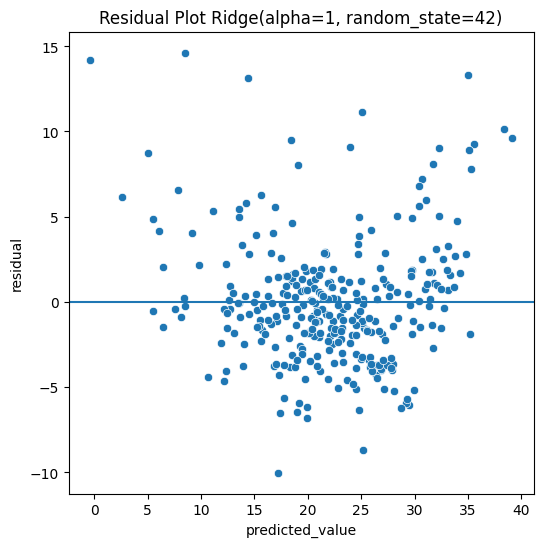

In [190]:
residualPlot(ridge_best, x_boston_train, y_boston_train)

1. Checking linearity assumptions via residual plots:
> Invalid, because it looks like the letter U or V
2. Check the assumption that residuals have constant variance:
> Invalid, because the lower limit of convex is not constant
3. Check the assumption of uncorrelated residuals between different types
observation
> Valid, because it forms a cluster, and no pattern is found

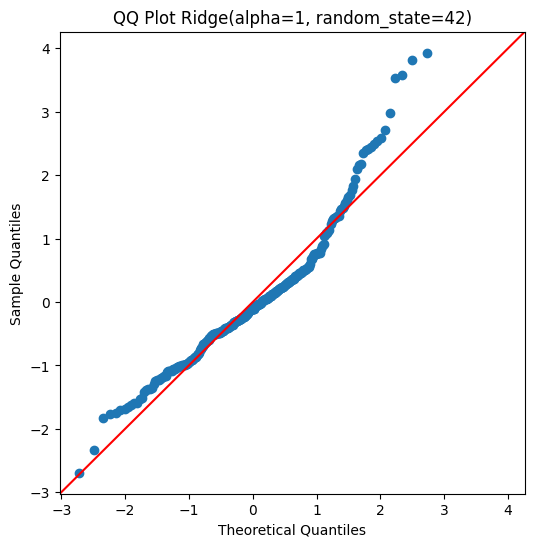

In [129]:
qqPlot(ridge_best, x_boston_train, y_boston_train)

4. Check the assumption that the residuals are normally distributed
> Underfit / invalid, because many points have deviations from the normal line

#### **Homoscedasticity Test Lasso**

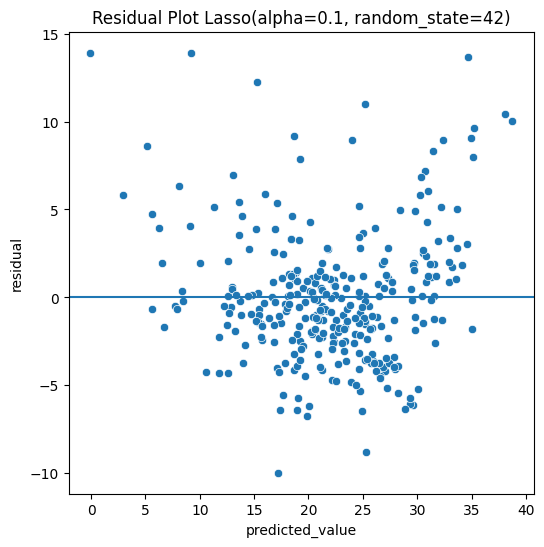

In [189]:
residualPlot(lasso_best, x_boston_train, y_boston_train)

1. Checking linearity assumptions via residual plots:
> invalid, because it looks like the letter U or V
2. Check the assumption that residuals have constant variance:
> invalid, because the lower limit of convex is not constant
3. Check the assumption of uncorrelated residuals between different types
observation
> valid, because it forms a cluster, and no pattern is found

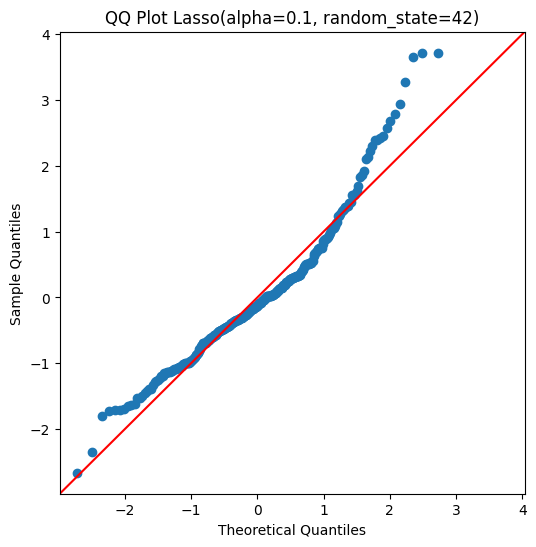

In [128]:
qqPlot(lasso_best, x_boston_train, y_boston_train)

4. Check the assumption that the residuals are normally distributed
> Underfit / invalid, because many points have deviations from the normal line

## **Conclusion**

1. Based on statistical tests, where the p value is less than alpha of 0.05, it can be said that the features has a significant influence on house prices.
2. The dataset may be too small and may not be varied enough to describe the model. Indicating the test result indicates overfitting compared to the training result.
3. Both models (Ridge and Lasso) may not be appropriate for predicting MEDV.